In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import numpy as np
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi

%matplotlib inline


In [2]:
def sem(data):
    return data.std()/np.sqrt(len(data))


In [3]:
#def conn_strength_2(strOne,strTwo):
#strOne must be a structure in thalamus
#strTwo is a layer of the primary motor cortex

drive_path = '/Volumes/Brain2016'


resolution_um=25
manifest_file = os.path.join(drive_path, "MouseConnectivity","manifest.json")
mcc = MouseConnectivityCache(manifest_file=manifest_file, resolution=resolution_um)

all_experiments = mcc.get_experiments(dataframe=True)

ontology = mcc.get_ontology()

strOne = 'MOp'
strTwo = 'DORsm'

str1 = ontology[strOne]
str1_desc = ontology.get_descendants(str1.id)



# get the adult mouse structures summary structures

oa = OntologiesApi()
set_name = [oa.quote_string('Mouse Connectivity - Summary')]
summary_structures = oa.get_structures(structure_set_names=set_name)
summary_structure_ids = [ s['id'] for s in summary_structures ]


cre_str1_experiments = mcc.get_experiments(cre = ['Chrna2-Cre_OE25','Etv1-CreERT2','Gpr26-Cre_KO250', 'Rbp4-Cre_KL100',
                                                  'Rorb-IRES2-Cre','Sim1-Cre_KJ18','Tlx3-Cre_PL56'], injection_structure_ids=str1['id'])
cre_str1_exps_df = pd.DataFrame(cre_str1_experiments)

str1_children = ontology[strTwo]
#print str1['id']
#print ('Structure Two ID:',str1_children['id'])


structure_unionizes_str1 = mcc.get_structure_unionizes([ e['id'] for e in cre_str1_experiments ], 
                                              is_injection=None,
                                              structure_ids=[str1['id'], str1_children['id']])

ipsi_source = structure_unionizes_str1[(structure_unionizes_str1.hemisphere_id == 3) & 
                                   (structure_unionizes_str1.normalized_projection_volume > .8) &
                                   (structure_unionizes_str1.is_injection == True) &
                                   (structure_unionizes_str1.structure_id == float(str1.id))]
X = ipsi_source.pivot(index='experiment_id', columns='structure_id', values='projection_volume')

ipsi_target = structure_unionizes_str1[(structure_unionizes_str1.hemisphere_id == 3) & 
                                   (structure_unionizes_str1.is_injection == False) &
                                   (structure_unionizes_str1.structure_id == float(str1_children.id))]
Ydash = ipsi_target.pivot(index='experiment_id', columns='structure_id', values='projection_volume')
Y = Ydash.loc[X.index]


trans = all_experiments.loc[Y.index]['transgenic-line']

weight = Y.values/X.values

df = pd.DataFrame(trans)
expt_ids = df.index.values
lines = df['transgenic-line'].values
weight = np.squeeze(weight)
data_dict = {}
data_dict['experiment_id']=expt_ids
data_dict['transgenic_line']=lines
data_dict['weight']=weight


xy = pd.DataFrame(data_dict)
#yz = xy.sort(columns = 'transgenic_line')    
df1 = xy.sort_values(['transgenic_line', 'weight'], ascending=[True, True])
mean1 =  df1.groupby('transgenic_line')['weight'].mean()
sd1 = df1.groupby('transgenic_line')['weight'].std()
sem1 = df1.groupby('transgenic_line')['weight'].sem()
    
data_dict2 = {}
data_dict2['mean'] = mean1
data_dict2['std'] = sd1
data_dict2['sem'] = sem1
df2 = pd.DataFrame(data_dict2)
df3 = df2.sort_values(['std'], ascending=[True])

    


In [19]:
df1 

,experiment_id,transgenic_line,weight
14,298273313,Chrna2-Cre_OE25,0.155015
15,298325807,Chrna2-Cre_OE25,0.238137
6,267750528,Chrna2-Cre_OE25,0.403909
10,292173552,Chrna2-Cre_OE25,0.566995
4,167569313,Etv1-CreERT2,0.083535
1,156492394,Etv1-CreERT2,0.108246
5,181598954,Gpr26-Cre_KO250,0.459476
16,301267162,Gpr26-Cre_KO250,0.606287
2,166082128,Rbp4-Cre_KL100,0.327851
0,120814821,Rbp4-Cre_KL100,0.643804


In [4]:
df3

,mean,sem,std
transgenic_line,,,
Etv1-CreERT2,0.095891,0.012356,0.017474
Gpr26-Cre_KO250,0.532881,0.073405,0.103811
Chrna2-Cre_OE25,0.341014,0.091380,0.182759
Rbp4-Cre_KL100,0.547958,0.110359,0.191147
Sim1-Cre_KJ18,0.258344,0.091886,0.205464
Tlx3-Cre_PL56,0.000103,NaN,NaN


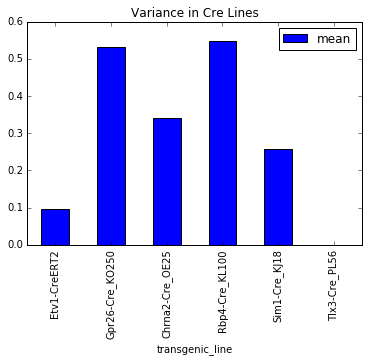

In [6]:
df3.plot.bar(y = ['mean'],title = 'Variance in Cre Lines',stacked = True, yerr = ['sem'])

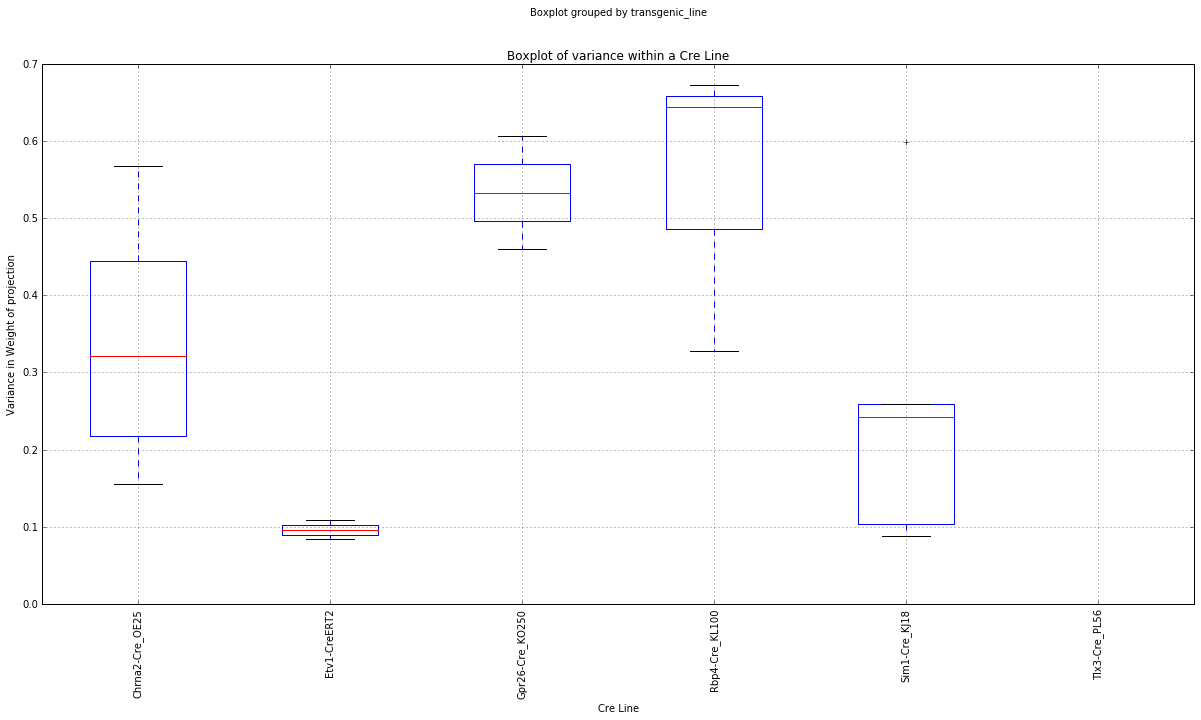

In [11]:
df1.boxplot(column='weight',by = 'transgenic_line',figsize = (20,10),rot = 90)
plt.title('Boxplot of variance within a Cre Line')
plt.xlabel('Cre Line')
plt.ylabel('Variance in Weight of projection')

In [12]:
df3.var()

mean    0.050128
sem     0.001432
std     0.006263
dtype: float64

In [13]:
df3.cov()

,mean,sem,std
mean,0.050128,0.005227,0.007063
sem,0.005227,0.001432,0.002837
std,0.007063,0.002837,0.006263


In [14]:
df1.var()

experiment_id    4.450137e+15
weight           5.140631e-02
dtype: float64

In [15]:
df1.corr()

,experiment_id,weight
experiment_id,1.000000,-0.211427
weight,-0.211427,1.000000


In [16]:
df3.corr()

,mean,sem,std
mean,1.000000,0.724214,0.467895
sem,0.724214,1.000000,0.947344
std,0.467895,0.947344,1.000000


In [17]:
df3.corr(df3.index)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

experiment_id   NaN
mean            NaN
sem             NaN
std             NaN
weight          NaN
dtype: float64

NameError: name 'allensdk' is not defined

In [24]:
help(OntologiesApi)

Help on class OntologiesApi in module allensdk.api.queries.ontologies_api:

class OntologiesApi(allensdk.api.queries.rma_template.RmaTemplate)
 |  See: `Atlas Drawings and Ontologies
 |  <http://help.brain-map.org/display/api/Atlas+Drawings+and+Ontologies>`_
 |  
 |  Method resolution order:
 |      OntologiesApi
 |      allensdk.api.queries.rma_template.RmaTemplate
 |      allensdk.api.queries.rma_api.RmaApi
 |      allensdk.api.api.Api
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, base_uri=None)
 |  
 |  get_atlases(self)
 |  
 |  get_atlases_table(self, atlas_ids=None, brief=True)
 |      List Atlases available through the API
 |      with associated ontologies and structure graphs.
 |      
 |      Parameters
 |      ----------
 |      atlas_ids : integer or list of integers, optional
 |          only select specific atlases
 |      brief : boolean, optional
 |          True (default) requests only name and id fields.
 |      
 |      Returns
 | 

In [25]:
conn_strength('TH','MOp')

NameError: name 'conn_strength' is not defined

In [ ]:
from 